In [ ]:
# 最基本的RNN模型

In [1]:
# GPU -- 准备来做一个GPU版本的RNN
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt

# 设置 GPU 优先
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# 加载数据
dataset = pd.read_csv("601229.csv", index_col=0)
dataset = dataset.drop(['date','prediction'], axis=1)
# print(dataset.columns)
# print(dataset.tail())
dataset['future'] = dataset['future']
print(dataset.shape)
# print(dataset.tail())

# 方法2，将数据按照BATCH_SIZE的窗口进行滑动，每个窗口数据做一组

# # 数据转成sequence的格式，这里定义每个seq的长度
seq_len = 45
BATCH_SIZE = 1                                                    # 注意：BATCH_SIZE是要能够整除seq_count的

# 把数据切换成 BATCH_SIZE 的一个个batch
rolling_data = pd.DataFrame()
for i in dataset.rolling(seq_len):
    if i.shape[0] == seq_len:
        rolling_data = rolling_data.append(i)

rolling_data = rolling_data.values.reshape(-1, seq_len, dataset.shape[1])                 # 数据一共是 seq_count x seq_len x (in_dim+1)

print("rolling_data shape: {}".format(rolling_data.shape))
print("seq count: {}".format(rolling_data.shape[0]))                                       # 所以一共有 seq_count 列数据，每一行的数据是123维 （包括y）
print("seq length: {}".format(seq_len))


total_batch_count = int(rolling_data.shape[0]/BATCH_SIZE)                                   # 把数据规划成 batch_count 个 batch

print("total batch count: {}".format(total_batch_count))
print("batch size: {}".format(BATCH_SIZE))

rolling_data = rolling_data.reshape(total_batch_count, BATCH_SIZE, seq_len, dataset.shape[1])  # 把数据转成 total_batch_count x BATCH_SIZE x seq_len x in_dim 格式
rolling_data = torch.tensor(rolling_data)
print("rolling_data: {}".format(rolling_data.shape))


train_batch_count = total_batch_count - 1
test_batch_count = total_batch_count - train_batch_count

train = rolling_data[:train_batch_count, :, :, :]
test  = rolling_data[train_batch_count:, :, :, :]

train_x, train_y = train[:,:,:,1:], train[:,:,:,0:1]
test_x,  test_y  = test[:,:,:, 1:],  test[:,:,:,0:1]

train_x = train_x.to(device)
train_y = train_y.to(device)
test_x = test_x.to(device)
test_y = test_y.to(device)

print("train_x: {}".format(train_x.shape))
print("train_y: {}".format(train_y.shape))
print("test_x:  {}".format(test_x.shape))
print("test_y:  {}".format(test_y.shape))
print("train_batch_count: {}".format(train_batch_count))
print("test_batch_count:  {}".format(test_batch_count))

(250, 123)
rolling_data shape: (206, 45, 123)
seq count: 206
seq length: 45
total batch count: 206
batch size: 1
rolling_data: torch.Size([206, 1, 45, 123])
train_x: torch.Size([205, 1, 45, 122])
train_y: torch.Size([205, 1, 45, 1])
test_x:  torch.Size([1, 1, 45, 122])
test_y:  torch.Size([1, 1, 45, 1])
train_batch_count: 205
test_batch_count:  1


In [5]:
# GPU -- 开始定义 RNN 模型
TIME_STEP = seq_len                                        # 一般这个单独设定，这里为了简单，还是直接就等于seq_len的方便。其实也就是等于最长的那个sequence length
INPUT_SIZE = 122
HIDDEN_SIZE = 256
NUM_LAYERS = 3

np.random.seed(3)
torch.manual_seed(3)
torch.cuda.manual_seed(3)
torch.backends.cudnn.deterministic = True

class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        
        self.dropout = nn.Dropout(p=0.5)
        
        self.rnn = nn.RNN(
                input_size = INPUT_SIZE,                    # 输入 x 的feature 维度
                hidden_size = HIDDEN_SIZE,                  # 隐状态 hidden_state 中的feature维度
                num_layers = NUM_LAYERS,                    # RNN 的层数
                nonlinearity='relu',                        # 指定激活函数 [‘tanh’ | ’relu’]. 默认: ‘tanh’
                bias = True,                                # 如果是 False , 那么 RNN 层就不会使用偏置权重 b_ih 和 b_hh, 默认: True
                batch_first = True,                         # 如果 True, 输入Tensor的shape应该是(BATCH_SIZE, seq_len, features),并且输出也是一样.
                dropout = 0.5,                              # 如果值非零, 那么除了最后一层外, 其它层的输出都会套上一个 dropout 层
                bidirectional = False                       # 如果 True , 将会变成一个双向 RNN, 默认为 False
        )
        
        self.fc_out = nn.Linear(HIDDEN_SIZE, 1)
        
        # weight的参数用kaiming初始化；bias用zeros初始化；
        for name, param in self.rnn.named_parameters():
            if name.startswith("weight"):
                nn.init.kaiming_normal_(param, nonlinearity='relu')
            else:
                nn.init.zeros_(param)

        # weight的参数用xavier初始化；bias用zeros初始化；
        # for name, param in self.rnn.named_parameters():
        #     if name.startswith("weight"):
        #         nn.init.xavier_normal_(param)
        #     else:
        #         nn.init.zeros_(param)
                
            
    def forward(self, x):
        x = self.dropout(x)
        
        h_state = torch.zeros(NUM_LAYERS, BATCH_SIZE, HIDDEN_SIZE).double().to(device)
        r_out, h_state = self.rnn(x, h_state)                         # compute from [1, seq_len, input_dim] to [1, seq_len, hidden_dim] 

        outs = []
        
        for time_step in range(TIME_STEP):
            out = self.fc_out(r_out[:, time_step, :])                 # compute from [1, 1, hidden_dim] to [output_dim]
            outs.append(out)                                          # Add all seq_len data to list like : [[pred1, pred2,...,predn]]
        
        return torch.stack(outs, dim=1)                               # conver from [[pred1,...,predn]] to [[[pred1], ... ,[prdn]]]


9 of 500 epoches get epoch_loss: 340.402532
[9.558895783575598e-06]
19 of 500 epoches get epoch_loss: 54.188278
[9.091562615825306e-06]
29 of 500 epoches get epoch_loss: 21.385265
[8.647077305675342e-06]
39 of 500 epoches get epoch_loss: 9.716085
[8.224322824348489e-06]
49 of 500 epoches get epoch_loss: 5.431642
[7.822236754458714e-06]
59 of 500 epoches get epoch_loss: 3.198843
[7.439808620067382e-06]
69 of 500 epoches get epoch_loss: 2.314738
[7.076077347272661e-06]
79 of 500 epoches get epoch_loss: 1.734534
[6.730128848950393e-06]
89 of 500 epoches get epoch_loss: 1.485230
[6.4010937275766645e-06]
99 of 500 epoches get epoch_loss: 1.322236
[6.088145090359076e-06]
109 of 500 epoches get epoch_loss: 1.240798
[5.790496471185969e-06]
119 of 500 epoches get epoch_loss: 1.110353
[5.507399854171277e-06]
129 of 500 epoches get epoch_loss: 1.102838
[5.238143793828016e-06]
139 of 500 epoches get epoch_loss: 1.051046
[4.982051627146237e-06]
149 of 500 epoches get epoch_loss: 1.022635
[4.7384797

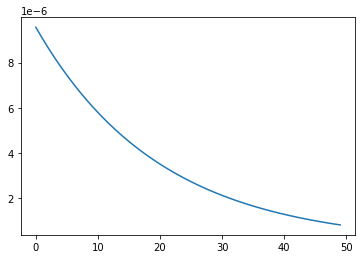

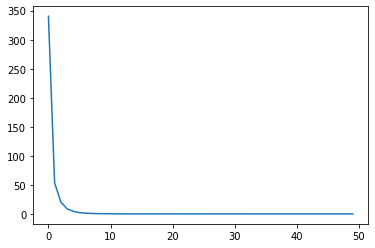

Wall time: 1h 45min 57s


In [6]:
%%time
# GPU -- 初始化 RNN 模型
model = RNN()
model.double().to(device)
LR = 1e-5
epoches = 500

epoch_loss_list = []
epoch_loss = 0
lr_list = []



# loss_func = nn.L1Loss()
loss_func = nn.MSELoss(reduction="mean")
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-3)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epoches, eta_min=0, last_epoch=-1)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.995, last_epoch=-1)


# 训练 RNN 模型; 计划训练 100 轮
for epoch in range(epoches):
    for step in range(train_batch_count):
        pred = model(train_x[step])
        pred.to(device)
        # h_state = h_state.data.to(device)

        loss = loss_func(pred, train_y[step])
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=20, norm_type=2)
        optimizer.step()
        
        epoch_loss += loss.data
    

    if (epoch+1)%10 == 0:
        print("{} of {} epoches get epoch_loss: {:.6f}".format(epoch, epoches, epoch_loss))
        lr_list.append(optimizer.state_dict()['param_groups'][0]['lr'])
        epoch_loss_list.append(epoch_loss.cpu())
        # print(optimizer.state_dict()['param_groups'][0]['lr'])
        # for p in optimizer.param_groups:
        #     p['lr'] *= 0.9
        print(scheduler.get_last_lr())
    
    scheduler.step()    

    epoch_loss = 0

plt.plot(lr_list)
plt.show()
                   
plt.plot(epoch_loss_list)
plt.show()

Prediction: -0.00
loss : 0.002546


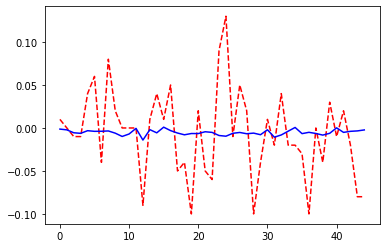

In [7]:
# GPU -- 用模型来做测试数据的误差

for step in range(test_batch_count):
    pred = model(test_x[step])

    loss = loss_func(pred, test_y[step].to(device))

    print("Prediction: {:.2f}".format(float(pred[-1][-1].data)))
    
    print("loss : {:.6f}".format(float(loss.data)))

    # print(test_y[step][-1].flatten().shape)
    # print(pred[-1].flatten().shape)
    
    # actual_line = test_y[step][-1].cpu().detach().flatten().numpy()
    # pred_line   = pred[-1].cpu().detach().flatten().numpy()
    
    actual_line = test_y[step].cpu().detach().flatten().numpy()
    pred_line   = pred.cpu().detach().flatten().numpy()
    
    plt.plot(actual_line, 'r--')
    plt.plot(pred_line, 'b-')
    plt.show()
    
# actual_line = np.array(test_y[-1]).flatten().tolist()
# pred_line = pred.data.numpy().flatten().tolist()

# actual_line = np.array(test_y[0][-1]).flatten().tolist()
# pred_line = pred[-1].data.numpy().flatten().tolist()


